# From Reversing Convolutions to VAEs

This notebook contains Tasks for the exercises in Deep Learning and Neural Nets 2.

In this Task, we will tackle the topic of auto-encoders,
a simple trick to use neural networks for unsupervised learning.
Whereas auto-encoders with fully connected layers are pretty simple,
new types of layers are necessary to build convolutional auto-encoders.
The most important of these new layers is the transposed convolution,
which is often confusingly referred to as a deconvolution.
Finally, we turn auto-encoders into generative models with some clever tricks.

In [ ]:
import os.path
import inspect
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision import models
import torch.nn.functional as F


from PIL import Image
from IPython.display import display
from torchvision.transforms.functional import to_pil_image

torch.manual_seed(1806)
torch.cuda.manual_seed(1806)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# google colab data management
import os.path

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    _home = 'gdrive/MyDrive/'
except ImportError:
    _home = '~'
finally:
    data_root = os.path.join(_home, '.pytorch')

print(data_root)

~/.pytorch


In [ ]:
class AutoMNIST(datasets.MNIST):
    """ Wrapper around MNIST for training auto-encoders. """

    def __getitem__(self, index):
        x = self.data[index].numpy()
        img = Image.fromarray(x, mode='L')
        target = Image.fromarray(x, mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    @property
    def raw_folder(self):
        return os.path.join(self.root, 'MNIST', 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, 'MNIST', 'processed')

In [ ]:
def download_image_data(url: str, md5: str = None, size: int = 224):
    """
    Download and pre-process some image for AlexNet.

    Parameters
    ----------
    url : str
        URL to the image.
    md5 : str, optional
        MD5 checksum of the image.
    size : int, optional
        Expected size for the image after cropping.

    Returns
    -------
    x : (1, 3, size, size) torch.Tensor
        Ready-to-predict image.
    """
    from torchvision.datasets.utils import download_url
    path = os.path.expanduser(data_root)
    download_url(url, path, md5=md5)
    file_name = url.rsplit('/', maxsplit=1)[-1]
    im = Image.open(os.path.join(path, file_name))
    # constants taken from torchvision.models docs
    normalise = transforms.Compose([
        transforms.RandomCrop(size=size),
        transforms.ToTensor(),
        transforms.Normalize((.485, .456, .406), (.229, .224, .225))
    ])
    return normalise(im).unsqueeze(0)

In [ ]:
def data_to_image(*data: torch.Tensor,
                  means: tuple = (0, ), stds: tuple = (1., )) -> Image:
    """
    Convert multiple tensors to one big image.

    Parameters
    ----------
    data0, data1, ... dataN : torch.Tensor
        One or more tensors to be merged into a single image.
    means : tuple or torch.Tensor, optional
        Original mean of the image before normalisation.
    stds : tuple or torch.Tensor, optional
        Original standard deviation of the image before normalisation.

    Returns
    -------
    image : Image
        PIL image with all of the tensors next to each other.
    """
    # concatenate all data
    big_pic = torch.cat([x for x in data], dim=-1)

    means = torch.tensor(means)
    stds = torch.tensor(stds)
    to_image = transforms.Compose([
        # inverts normalisation of image
        transforms.Normalize(-means / stds, 1. / stds),
        transforms.Lambda(lambda x: torch.clamp(x, 0, 1)),
        transforms.ToPILImage()
    ])

    return to_image(big_pic)

In [ ]:
class RegularisedLoss(nn.Module):
    """
    Loss function for networks that expose state for regularisation.

    Examples
    --------
    To train an auto-encoder with some norm-regularisation (untested):
    >>> ae = AutoEncoder(784)
    >>> mse = RegularisedLoss(nn.MSELoss(), torch.norm)
    >>> x = torch.randn(1, 784)
    >>> logits, code = ae.forward(x)
    >>> mse((logits, code), x)
    """

    def __init__(self, loss_func: nn.Module = None, reg_func: nn.Module = None,
                 weight: float = 1.):
        """
        Parameters
        ----------
        loss_func : nn.Module
            Standard loss function computed from logits and targets.
        reg_func : nn.Module, optional
            Regularisation function computed from exposed network state.
        weight : float, optional
            Weighting factor for the regularisation.
        """
        super().__init__()
        self.loss_func = loss_func
        self.regulariser = reg_func
        self.weight = weight
        self._regularisation_cache = []

    def split_loss(self, total_loss):
        """
        Split total loss values in original loss and regularisation part.

        Parameters
        ----------
        total_loss : list or float
            One or more loss values computed with this function.

        Returns
        -------
        orig_loss : Tensor
            One ore more loss values from the original part of the loss.
        reg_loss : Tensor
            One or more loss values from the regularsiation part of the loss.
        """
        if len(self._regularisation_cache) == 0:
            raise ValueError("no regularisation loss yet, make sure to call forward first")

        _totals = torch.tensor(total_loss)
        reg_loss = torch.tensor(self._regularisation_cache[-_totals.numel():])
        orig_loss = _totals - self.weight * reg_loss
        return orig_loss, reg_loss

    def forward(self, outputs, y):
        """
        Parameters
        ----------
        outputs : (Tensor, Tensor)
            Tuple consisting of logits and exposed state.
        y : Tensor
            Targets for the original loss part.
        """
        logits, state = outputs
        loss = self.loss_func(logits, y)

        if self.regulariser is not None:
            reg_loss = self.regulariser(state)
            self._regularisation_cache.append(reg_loss.item())
            loss = loss + self.weight * reg_loss

        return loss

In [ ]:
class AutoEncoderTrainer:

    def __init__(self,
         model: nn.Module,
         criterion: nn.Module,
         optimiser: optim.Optimizer,
    ):
        """
        Parameters
        ----------
        model : torch.nn.Module
            Neural Network that will be trained.
        criterion : torch.nn.Module
            Loss function to use for training.
        optimiser : torch.optim.Optimizer
            Optimisation strategy for training.
        tracker : Tracker, optional
            Tracker to keep track of training progress.
        """
        self.model = model
        self.criterion = criterion
        self.optimiser = optimiser


    def state_dict(self):
        """ Current state of learning. """
        return {
            "model": self.model.state_dict(),
            "objective": self.criterion.state_dict(),
            "optimiser": self.optimiser.state_dict(),
        }

    @property
    def device(self):
        """ Device of the (first) model parameters. """
        return next(self.model.parameters()).device

    def _forward(self, data: DataLoader, metric: callable):
        device = self.device

        for x, y in data:
            x, y = x.to(device), y.to(device)
            logits = self.model(x)
            res = metric(logits, y)
            yield res


    @torch.no_grad()
    def evaluate(self, data: DataLoader, metric: callable) -> list:
        self.model.eval()
        losses = [res.item() for res in self._forward(data, metric)]
        return losses


    @torch.enable_grad()
    def update(self, data: DataLoader) -> list:
        opt = self.optimiser
        self.model.train()

        errs = []
        for err in self._forward(data, self.criterion):
            errs.append(err.item())

            opt.zero_grad()
            err.backward()
            opt.step()

        return errs

    def _print_errs(self, epoch: int, errs : list):
        """
        Print error summary for current epoch.

        If possible, the loss is additionally decomposed in
        reconstruction and regularisation loss.

        Parameters
        ----------
        epoch : int
            Rank of the current epoch.
        errs : list
            The errors to summarise.
        """
        print(f"Epoch {epoch: 2d} - avg loss: {sum(errs) / len(errs):.6f}", end=' ')
        try:
            rec_errs, reg_errs = self.criterion.split_loss(errs)
            print(f"(rec: {sum(rec_errs) / len(errs):.4f}, reg: {sum(reg_errs) / len(errs):.4f})")
        except (AttributeError, ValueError):
            print()


    def _display_result(self, xs: torch.Tensor, count: int = 10):
        """
        Visualise a number of reconstructions from an auto-encoder.

        Parameters
        ----------
        xs : torch.Tensor
            Batch of images to be reconstructed.
            The batch is assumed to have the correct shape
            for feeding it to the network.
        count : int, optional
            Number of samples in the batch to visualise.

        """
        xs = xs[:count]
        # get reconstructions
        preds = self.model.reconstruct(xs.to(self.device)).cpu()

        # convert to images
        xs = xs.view(-1, 1, 28, 28)  # unflatten
        x_im = data_to_image(*xs, means=(.1307, ), stds=(.3081, ))
        preds = preds.view(-1, 1, 28, 28)
        res_im = data_to_image(*preds)

        # paste together
        im = Image.new('L', (len(xs) * 28, 56))
        im.paste(x_im, (0, 0))
        im.paste(res_im, (0, 28))
        display(im, metadata={'width': '100%'})


    def train(self, loader: DataLoader, num_epochs: int = 10, vis_every: int = 5):
        """
        Train an auto-encoder for a number of epochs.

        Parameters
        ----------
        loader : DataLoader
            A data loader for iterating over batches of the data.
        num_epochs : int, optional
            Number of times to iterate the dataset.
        vis_every : int, optional
            Frequency, during training, of
            intermediate visualisation of reconstructions.
        """
        # take random batch for visualising reconstructions
        ref_inputs, _ = next(iter(loader))

        # evaluate random performance
        errs = self.evaluate(loader, self.criterion)
        self._print_errs(0, errs)
        self._display_result(ref_inputs)

        # train for some epochs
        for epoch in range(1, num_epochs + 1):
            errs = self.update(loader)
            self._print_errs(0, errs)

            if epoch % vis_every == 0:
                self._display_result(ref_inputs)

## Auto-Encoders

An easy way to use supervised models in an unsupervised setting
is to invent a prediction task that only requires the inputs.
The most straightforward approach to this paradigm is to learn the identity function.
It is trivial to find a network that solves this task perfectly (linear regression).
In order to get more interesting models,
it is therefore important to make it slightly harder for the network to learn the identity.

The auto-encoder is a neural network architecture for learning these identity functions.
In general, auto-encoders consist of two parts:
the first part is the **encoder**, which maps the inputs to some *code*
and the second part is the **decoder**, which maps this code back to the inputs.
This setup is especially interesting when the code is much smaller than the input.
In this case, the code forms a bottleneck for the information flow,
and the network must learn to compress the information in the inputs to get good reconstructions.
This effectively allows to learn a lossy compression scheme where
the encoder can be used to compress the inputs and the decoder is used for decompression.

Typically, encoder and decoder will have some sort of symmetry in their architecture.
In fully-connected models, this symmetry can be obtained by transposing the weight matrices.
Convolutional layers can be transposed as well, although that might not be as obvious.
Note that we are only talking about the architecture, i.e. the shape of the weight matrices,
and not about the weights, which are typically **not shared** between encoder and decoder.

<div style="text-align: center">
  <figure style="display: inline-block; width: 49%; margin: 0">
    <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" />
    <figcaption style="width: 100%;"> Normal convolution </figcaption>
  </figure>
  <figure style="display: inline-block; width: 49%; margin: 0">
    <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides_transposed.gif" />
    <figcaption style="width: 100%; text-align: center;"> Transposed convolution </figcaption>
  </figure>
</div>



### Exercise 1: Transposed Convolutions
Although the transpose of a matrix is typically not its inverse,
it can be interpreted as a way to *undo* a matrix multiplication.
This is especially true for fully connected layers,
where we find the tranpose of the weight matrix in the backward pass.
Using this analogy, we can find a transposed convolution
by taking the operation we find in the backward pass of a conv layer.

To get a feeling for how transposed convolutions can *undo* convolutions,
we are going to be implementing a method from Zeiler and Fergus (from ZF net).
They used transposed convolutions to visualise activations in the input space.
However, we will also need to undo max-pooling layers and ReLU non-linearities.
Therefore, we first focus on how to undo different kinds of layers.
An example of how to undo a ReLU non-linearity is provided in `UndoableReLU`.

 > Implement the `undo` methods of the `UndoableMaxPool2d` and `UndoableConv2d` classes below.
 > As the title suggests, convolutions can be undone by transposed convolutions.
 > Pooling operations can generally be undone by upsampling operations.
 > However, for max-pooling, we can get better results
 > if we keep track of the indices in the original inputs.
 > Do not forget about the different parameters!

#Solution

In [ ]:
class UndoableReLU(nn.Module):
    """
    Wrapper around a relu layer that adds 'undo' functionality.
    """

    def __init__(self, module: nn.ReLU):
        super().__init__()
        self.original = module

    def forward(self, s: torch.Tensor):
        return torch.relu(s), None

    @torch.no_grad()
    def undo(self, a: torch.Tensor, context):
        return torch.relu(a)

In [ ]:
class UndoableMaxPool2d(nn.Module):
    """
    Wrapper around a max-pooling layer that adds 'undo' functionality.
    """

    def __init__(self, module: nn.MaxPool2d):
        super().__init__()
        self.original = module

    @property
    def kwargs(self):
        return {
            k: getattr(self.original, k)
            for k in ("kernel_size", "stride", "padding")
        }

    def forward(self, x: torch.Tensor):
        out, indices = nn.functional.max_pool2d(x, return_indices=True, **self.kwargs)
        return out, (indices, x.shape[-2:])

    @torch.no_grad()
    def undo(self, y: torch.Tensor, context):
        """
        Undo the operation from the forward pass.

        Parameters
        ----------
        y : torch.Tensor
            Data with same shape as the output of the original module.
        context
            Additional information to correctly undo the forward operation.
            This is typically the second term in the output of `forward`.
        """
        indices, input_shape = context
        return F.max_unpool2d(y, indices, **self.kwargs, output_size=input_shape)

In [ ]:
x = torch.ones(1, 3, 32, 32)
pool = nn.MaxPool2d(kernel_size=2)
wrapped = UndoableMaxPool2d(pool)
out, context = wrapped(x)
assert torch.allclose(out, pool(x))
assert wrapped.undo(out, context).shape == x.shape, (
    "ex1: MaxPool2d.undo produces incorrect shape (-0.5 points)"
)

In [ ]:
x = torch.ones(1, 3, 32, 32)
pool = nn.MaxPool2d(kernel_size=3)
wrapped = UndoableMaxPool2d(pool)
out, context = wrapped(x)
assert torch.allclose(out, pool(x))
assert wrapped.undo(out, context).shape == x.shape, (
    "ex1: MaxPool2d.undo does not (correctly) pad outputs (-0.5 points)"
)

In [ ]:
class UndoableConv2d(nn.Module):
    """
    Wrapper around a convolutional layer that adds 'undo' functionality.
    """

    def __init__(self, module: nn.Conv2d):
        super().__init__()
        self.original = module

    @property
    def kwargs(self):
        return {
            k: getattr(self.original, k)
            for k in ("padding", "stride", "dilation", "groups")
        }

    def forward(self, x: torch.Tensor):
        return nn.functional.conv2d(
            x, self.original.weight, self.original.bias, **self.kwargs
        ), x.shape[-2:]

    @torch.no_grad()
    def undo(self, s: torch.Tensor, context):
        input_height, input_width = context

        # Compute the output padding to ensure the output shape matches the input shape
        output_height = (s.shape[-2] - 1) * self.original.stride[0] - 2 * self.original.padding[0] + self.original.kernel_size[0] + self.original.output_padding[0]
        output_width = (s.shape[-1] - 1) * self.original.stride[1] - 2 * self.original.padding[1] + self.original.kernel_size[1] + self.original.output_padding[1]
        output_padding = (input_height - output_height, input_width - output_width)

        return nn.functional.conv_transpose2d(
            s, self.original.weight, None, stride=self.original.stride,
            padding=self.original.padding, dilation=self.original.dilation,
            groups=self.original.groups, output_padding=output_padding
        )


In [ ]:
x = torch.ones(1, 3, 32, 32)
conv = nn.Conv2d(3, 16, 7)
wrapped = UndoableConv2d(conv)
out, context = wrapped(x)
assert torch.allclose(out, conv(x)) and context == (32, 32)
assert wrapped.undo(out, context).shape == x.shape, (
    "ex1: Conv2d.undo produces incorrect shape (-0.5 points)"
)

In [ ]:
x = torch.ones(1, 3, 32, 32)
conv = nn.Conv2d(3, 16, 7, stride=2)
wrapped = UndoableConv2d(conv)
assert wrapped.undo(*wrapped(x)).shape == x.shape, (
    "ex1: Conv2d.undo does not (correctly) pad outputs (-0.5 points)"
)

### Exercise 2: Visualising Features

In the previous exercise I mentioned Zeiler and Fergus.
They used this kind of undoable modules to visualise features.
I think it is worth trying this out for yourself.
Is there anything we can learn from these visualisations?

 > Implement the `visualise_activations` method of `UndoableSequential`.
 > The `wrapped` attribute gives you the undoable versions of each layer.
 > This way, you should be able to compute activations with context.
 > These activations with context can eventually be *undone* to obtain visualisations.
 > Rather than visualising all activations at once, however,
 > the goal should be to keep the `k` highest values and set other values to zero.
 > You can use the `keep_top_k` function to do this.

#Solution

In [ ]:
def keep_top_k(tensor: torch.Tensor, k: int = 9) -> torch.Tensor:
    """
    Drop all but the K highest entries in a tensor.

    Parameters
    ----------
    tensor : torch.Tensor
        The tensor to start from.
    k : int
        The number of entries to keep.

    Returns
    -------
    result : torch.Tensor
        A tensor with only the K highest entries of `tensor`
        in the corresponding positions.
        All other entries are zero.
    """
    result = torch.zeros_like(tensor)
    vals, indices = torch.flatten(tensor, start_dim=1).topk(k, dim=-1)
    torch.flatten(result, start_dim=1).scatter_(-1, indices, vals)
    return result

In [ ]:
class UndoableSequential(nn.Module):
    """
    Wrapper around a sequential layer that adds 'undo' functionality.
    """

    UNDOABLE_MODULES = {
        nn.Conv2d: UndoableConv2d,
        nn.MaxPool2d: UndoableMaxPool2d,
        nn.ReLU: UndoableReLU,
    }

    def __init__(self, module: nn.Sequential):
        super().__init__()
        self.original = module
        self.wrapped = nn.ModuleList([
            self.UNDOABLE_MODULES[type(m)](m) for m in module
        ])

    def forward(self, x: torch.Tensor, until: int = None):
        context = []
        for module in self.wrapped[:until]:
            x, ctx = module(x)
            context.append(ctx)
        return x, context

    def visualise_activations(self, x: torch.Tensor, layer: int = None, k: int = 9):
        """
        Visualise activations in input space.

        Parameters
        ----------
        x : torch.Tensor
            The data for which the activations should be visualised.
        layer : int, optional
            The layer to visualise the activations for.
            By default, activations in the last layer are visualised.
        k : int, optional
            The number of activations to visualise.

        Returns
        -------
        visualisation : torch.Tensor
            The visualisations with the same shape as `x`.
        """
        if layer is None:
            layer = len(self.wrapped)

        activations, context = self.forward(x, until=layer)

        for i in reversed(range(layer)):
            ctx = context[i]
            activations = keep_top_k(activations, k)
            activations = self.wrapped[i].undo(activations, ctx)

        return activations


In [ ]:
# download some random 256x256 kitten image
kitten_url = 'https://homes.cs.washington.edu/~moreau/media/vta/cat.jpg'
kitten_md5 = 'b852db33459ff958c9bba4e015cb37eb'
x_im = download_image_data(kitten_url, kitten_md5)

# download trained network
net = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

100%|██████████| 123126/123126 [00:00<00:00, 879261.14it/s]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 165MB/s]  


In [ ]:
seq = UndoableSequential(net.features)
vis_layer1 = seq.visualise_activations(x_im, layer=1)

assert vis_layer1.shape == x_im.shape, (
    "ex2: first layer vis does not have correct shape (-0.5 points)"
)
assert torch.count_nonzero(vis_layer1.sum(1)) <= 1089, (
    "ex2: too many non-zero values in first layer vis for k=9 (-0.5 points)"
)

In [ ]:
vis_layer2 = seq.visualise_activations(x_im, layer=4)
assert vis_layer2.shape == x_im.shape, (
    "ex2: fourth layer vis does not have correct shape (-0.5 points)"
)
assert torch.count_nonzero(vis_layer2.sum(1)) <= 24336, (
    "ex2: too many non-zero values in fourth layer vis for k=9 (-0.5 points)"
)

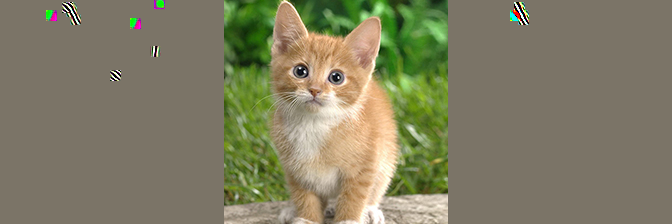

In [ ]:
# sanity check
out = data_to_image(vis_layer1[0], x_im[0], vis_layer2[0],
                    means=(.485, .456, .406), stds=(.229, .224, .225))
display(out, metadata={'width': '100%'})

### Exercise 3: Convolutional Auto-Encoders

Architecturally an auto-encoder is not much more than a model
where inputs and outputs have the same dimensions.
For fully-connected networks this is relatively straightforward.
However, with our newly acquired knowledge on transposed convolutions,
also convolutional and pooling layers should not pose too much problems.
One key difference is that the transposed convolutions n an auto-encoder
will have their own learnable parameters.

The architecture is typically symmetrical and consists of two parts:

 1. an **encoder** that transforms the image to some latent space and
 2. a **decoder** that produces an image from vectors in the latent space.

Since both components can operate independently from each other,
auto-encoders can be used to e.g. learn compression algorithms.
Because the output of both networks can be useful,
it is typically a good idea to have them predict logits,
i.e. not to use activation functions at the end.
This way, both the output of the encoder
and the output of the decoder can be used in loss functions.

 > Implement the `AutoEncoder` class with an `encoder` and a `decoder` network.
 > The `encoder` network should have at least
 > one average-pooling and two convolutional layers.
 > The `decoder` architecture should be symmetric to that of the `encoder`,
 > except for the exact placement of activation functions.
 > The `forward` method should aim to reconstruct the inputs
 > using the `encoder` and `decoder` networks.
 > You can ignore the `to_intensities` and `reconstruct` methods (for now).

**Hint:** Average pooling can be *undone* by upsampling the image.

#Solution

In [ ]:
class AutoEncoder(nn.Module):
    """ Convolutional auto-encoder. """

    def __init__(self, in_channels: int, hid_channels: int, code_channels: int,
                 kernel_size: int, stride: int = 1, pooling: int = 2,
                 activation: nn.Module = nn.ReLU(), assumption: str = None):
        super().__init__()
        self.assumption = assumption
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hid_channels, kernel_size, stride, padding=kernel_size // 2),
            activation,
            nn.Conv2d(hid_channels, hid_channels, kernel_size, stride, padding=kernel_size // 2),
            activation,
            nn.AvgPool2d(pooling)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hid_channels, hid_channels, pooling, stride=pooling),
            activation,
            nn.ConvTranspose2d(hid_channels, hid_channels, kernel_size, stride=stride, padding=kernel_size // 2),
            activation,
            nn.ConvTranspose2d(hid_channels, in_channels, kernel_size, stride=stride, padding=kernel_size // 2),
            nn.Sigmoid()  # Apply Sigmoid activation to ensure values in [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


    def reconstruct(self, x):
        # Define the reconstruction process here
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed


In [ ]:
ae = AutoEncoder(1, 1, 1, 3)
assert len(ae.encoder) > 3, (
    "ex3: encoder has too little modules (-1 point)"
)

In [ ]:
ae = AutoEncoder(1, 1, 1, 3)
assert len(ae.decoder) > 3, (
    "ex3: decoder has too little modules (-1 point)"
)

In [ ]:
ae = AutoEncoder(1, 16, 8, 5)
x = torch.randn(1, 1, 28, 28)
y = ae(x)
assert x.shape == y.shape, (
    f"ex3: reconstructed input has different shape: {tuple(y.shape)} (-0.5 points)"
)

### Exercise 4: Auto-Encoding

Of course, training an auto-encoder takes more than just a nice architecture.
The loss function as well as the pre-processing of data will also affect the results.
There is no right or wrong as long as you get the desired result.
However, we can make certain assumptions to guide the search for a good combination.
After all, all components have to work together to get nice reconstructions.
Can you spot/explain the difference in results for different assumptions?

 > Train the simple auto-encoder from exercise 3 on the AutoMNIST dataset.
 > Fill out the template code below using the `AutoEncoderTrainer` class,
 > which has been defined in the "preamble" of this assignment.
 > Your main task will be to choose a loss function and set up pre-processing of the targets.
 > Use the `assumption` kwarg of the `AutoEncoder` class to indicate your assumptions.
 > This should also guarantee correct visualisations of the reconstructions.
 > Make sure that the assumption matches the chosen loss function and pre-processing.
 > Feel free to add assumptions in the `reconstruct` method if you feel something is missing.

**Hint:** A few `assumption` options are provided in the documentation of `AutoEncoder.__init__`

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 39352045.22it/s]


Extracting /root/.pytorch/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 1207529.07it/s]

Extracting /root/.pytorch/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 9353598.06it/s]


Extracting /root/.pytorch/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 2877723.38it/s]

Extracting /root/.pytorch/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST/raw



Epoch  0 - avg loss: 1.213622 


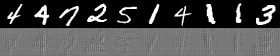

Epoch  0 - avg loss: 0.480104 
Epoch  0 - avg loss: 0.466836 
Epoch  0 - avg loss: 0.465595 
Epoch  0 - avg loss: 0.464998 
Epoch  0 - avg loss: 0.464553 


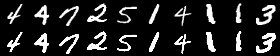

Epoch  0 - avg loss: 0.464322 
Epoch  0 - avg loss: 0.464009 
Epoch  0 - avg loss: 0.463852 
Epoch  0 - avg loss: 0.463816 
Epoch  0 - avg loss: 0.463683 


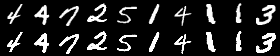

In [ ]:
target_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.1307,), (.3081,))
])

data = AutoMNIST(
    data_root,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.1307,), (.3081,))
    ]),
    target_transform=target_transform,
)
# Assumption for the AutoEncoder
assumption = "probabilistic"

# Loss function
criterion = nn.MSELoss()

# Initialize AutoEncoder model
auto_encoder = AutoEncoder(
    1, 64, 16, 5, activation=nn.ELU(),
    assumption=assumption,
).to(device)

# Initialize AutoEncoderTrainer
trainer = AutoEncoderTrainer(
    model=auto_encoder,
    criterion=criterion,
    optimiser=optim.Adamax(auto_encoder.parameters()),
)

# DataLoader
loader = DataLoader(data, batch_size=256, shuffle=True, num_workers=4)

# Training loop
trainer.train(loader, num_epochs=10)


In [ ]:
assert len(data.transform.transforms) == 2, (
    "ex4: input transform should not be altered! (-1 point)"
)

try:
    x_in, x_out = data[0]
    assert torch.is_tensor(x_in) and torch.is_tensor(x_out), (
        "ex4: pre-processing does not produce tensors (-1 point)"
    )
except (TypeError, RuntimeError):
    raise AssertionError(
        "ex4: pre-processing is broken (-1 point)"
    ) from None

In [ ]:
x_rec = auto_encoder.reconstruct(torch.randn(16, 1, 28, 28).to(device))
assert x_rec.min() >= 0 and x_rec.max() <= 1, (
    "ex4: invalid range for reconstructed values: "
    f"[{x_rec.min().item(), x_rec.max().item()}] (-1 point)"
)

Epoch  0 - avg loss: 0.463626 


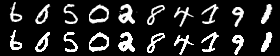

Epoch  0 - avg loss: 0.463601 
Epoch  0 - avg loss: 0.463480 
Epoch  0 - avg loss: 0.463480 
Epoch  0 - avg loss: 0.463473 
Epoch  0 - avg loss: 0.463418 


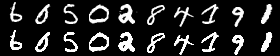

Epoch  0 - avg loss: 0.463358 
Epoch  0 - avg loss: 0.463361 
Epoch  0 - avg loss: 0.463448 
Epoch  0 - avg loss: 0.463339 
Epoch  0 - avg loss: 0.463285 


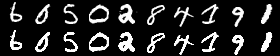

In [ ]:
# sanity check
loader = DataLoader(data, batch_size=256, shuffle=True, num_workers=4)
trainer.train(loader, num_epochs=10)

## Variational Auto-Encoders

Variational auto-encoders (VAEs) extend auto-encoders in a probabilistic way.
Although this might sound complicated, it only requires a few modifications to make an auto-encoder variational.
First of all, the latent space is regularised to stay close to a (standard normal) distribution.
Secondly, VAEs do not produce specific codes, but rather a distribution of codes.
In practice this is done by directly mapping inputs to the parameters of a distribution.

The main advantage of this approach, is that the the distribution of the latent codes remains well under control.
As a result, we can sample from this latent distribution and decode these sampled codes to generate new data.

### Exercise 5: Variational Auto-Encoder

VAEs predict the distribution parameters of the latent space,
rather than a specific code in the latent space.
In the case of a Gaussian latent distribution,
this means that the encoder produces a mean and log-variance for every input sample.
By predicting the log-variance, the variance is guaranteed to be positive.

Because the codes of a VAE are distributions, it is not possible to directly decode them back to images.
Instead, specific codes have to be sampled from the latent distribution before decoding.
This is the main difference, architecturally, between AEs and VAEs.
The main difference during training is the regularisation.
This is what makes VAEs especially interesting for generating new images.

 > Implement the `VariationalAutoEncoder` class.
 > The `sample` method should sample a latent vector from a Gaussian with given mean and log-variance.
 > Note that the `sample` method for a VAE must be differentiable!
 > In addition to the regular output,
 > the `forward` method should also return the distribution parameters.
 > These can then be used to compute the regularisation loss,
 > which should be implemented in the `regularisation` method.

In [ ]:
class VariationalAutoEncoder(nn.Module):
    """ Variational auto-encoder with standard normal prior. """

    @staticmethod
    def sample(mean: torch.Tensor, log_var: torch.Tensor):
        """
        Sample randomly from the latent space in a differentiable manner.

        Parameters
        ----------
        mean : (N, code_features) Tensor
            Mean(s) for sampling new images.
        log_var : (N, code_features) Tensor
            Logarithm of variance(s) for sampling new images.

        Returns
        -------
        sample : (N, code_features) Tensor
            The randomly generated sample in latent space.
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    @staticmethod
    def regularisation(parameters: tuple[torch.Tensor, torch.Tensor]):
        """
        Compute regularisation loss.

        Parameters
        ----------
        parameters : (Tensor, Tensor)
            Mean and log_var predictions from forward pass.

        Returns
        -------
        kl_div : Tensor
            The Kullback-Leibler divergence between a standard normal
            and the Gaussian distribution specified by `parameters`.
        """
        mean, log_var = parameters
        kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return kl_div

    def __init__(self, encoder: nn.Module, decoder: nn.Module,
                 assumption: str = None):
        super().__init__()
        self.assumption = assumption
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x: torch.Tensor):
        """
        Parameters
        ----------
        x : torch.Tensor
            The inputs to the forward pass.

        Returns
        -------
        y : torch.Tensor
            The logits computed from `x`
        parameters : tuple of torch.Tensor
            The parameters for the latent distribution.
            This is used to compute the regularisation.
        """
        encoded = self.encoder(x)
        mean, log_var = encoded[:, :encoded.shape[1] // 2], encoded[:, encoded.shape[1] // 2:]
        z = self.sample(mean, log_var)
        y = self.decoder(z)
        return y, (mean, log_var)

    @torch.no_grad()
    def generate(self, mean: torch.Tensor, log_var: torch.Tensor = None,
                 y_range: tuple[float, float] = None) -> torch.Tensor:
        """
        Generate one or more new images.

        Parameters
        ----------
        mean : (N, code_features) Tensor
            Mean in latent space for generating images.
        log_var : (N, code_features) Tensor, optional
            Logarithm of variance(s) in latent space for generating images.
        y_range : tuple of float, optional
            Range of pixel intensities in the generated images.

        Returns
        -------
        img : (N, in_features) Tensor
            Image with the same dimensions as the inputs
            and pixel intensities in [0, 1].

        See Also
        --------
        `sample(mean, log_var)` : sample randomly in latent space.
        """
        if log_var is None:
            log_var = torch.zeros_like(mean)  # Assuming log_var is zeros by default
        device = next(self.encoder.parameters()).device
        mean = mean.to(device)
        log_var = log_var.to(device)
        z = self.sample(mean, log_var)
        logits = self.decoder(z)
        return torch.sigmoid(logits)

    @torch.no_grad()
    def reconstruct(self, x):
        """ Reconstruct inputs to proper images. """
        logits, _ = self.forward(x)
        # Assuming logits are intensities, clip them to [0, 1] range
        reconstructions = torch.clamp(logits, 0, 1)
        return reconstructions


In [ ]:
mean, log_var = torch.ones(1024, 10), torch.zeros(1024, 10)
z = VariationalAutoEncoder.sample(mean, log_var)
assert z.shape == mean.shape, (
    "ex5: incorrect shape for sampled VAE latents (-1 point)"
)
assert torch.allclose(z.mean(0), torch.ones(1), atol=1e-1), (
    "ex5: incorrect mean for sampled VAE latents: "
    f"'{z.mean(0).abs().max().item():.3f}' (-1 point)"
)

In [ ]:
mean = torch.zeros(1024, 10).requires_grad_(True)
log_var = torch.zeros(1024, 10).requires_grad_(True)
z = VariationalAutoEncoder.sample(mean, log_var)
assert z.requires_grad, (
    "ex5: reparameterisation trick not (correctly) implemented (-2 points)"
)

In [ ]:
mean, log_var = torch.zeros(1, 10), torch.zeros(1, 10)
reg = VariationalAutoEncoder.regularisation((mean, log_var))
assert torch.allclose(reg, torch.zeros(1)), (
    "ex5: VAE regulariser for perfect parameters is not zero (-1 point)"
)

reg = VariationalAutoEncoder.regularisation((mean + 1, log_var))
assert torch.allclose(reg, 5 * torch.ones(1)), (
    "ex5: VAE regulariser for parameters with shifted mean is wrong: "
    f"'{reg.item():.3f}' != 5.0 (-1 point)"
)

In [ ]:
vae = VariationalAutoEncoder(
    encoder=nn.Sequential(
        nn.Linear(784, 400), nn.ELU(), nn.Linear(400, 20)
    ), decoder=nn.Sequential(
        nn.ELU(), nn.Linear(10, 400), nn.ELU(), nn.Linear(400, 784)
    )
)

x = torch.ones(1, 784)
y, pars = vae(x)
assert y.shape == x.shape, (
    f"ex5: reconstructed input has different shape: {tuple(y.shape)} (-0.5 points)"
)
assert pars[0].shape == pars[1].shape, (
    f"ex5: latent distribution parameters have different shapes (-0.5 points)"
)

In [ ]:
x = torch.ones(1, 784)
y1, _ = vae(x)
y2, _ = vae(x)
assert not torch.allclose(y1, y2), (
    f"ex5: forward pass seems to be deterministic (-0.5 points)"
)

### Exercise 6: Balance

In order to incorporate the regularisation loss in our trainer,
I provided a (hacky) loss function wrapper: `RegularisedLoss`.
This wrapper makes it possible to observe the original loss
together with the regularisation loss.
This will be useful because regularisation is always a balancing act.
Therefore, the goal of this final exercise is to train the VAE
in such a way that reconstruction and regularisation losses are balanced.

 > Train the variational auto-encoder with the regularised loss.
 > You can copy your reconstruction assumptions and loss function
 > from the auto-encoder exercise (they are not graded twice).
 > The key will be to find a reasonable value for the weight!

In [ ]:
# Set up VAE architecture
vae = VariationalAutoEncoder(
    encoder=nn.Sequential(
        nn.Flatten(), nn.Linear(784, 400),
        nn.ELU(), nn.Linear(400, 40),
    ),
    decoder=nn.Sequential(
        nn.ELU(), nn.Linear(20, 400),
        nn.ELU(), nn.Linear(400, 784),
        nn.Unflatten(1, (1, 28, 28)),
    ),
    assumption=None
).to(device)

# Define reconstruction assumption and regularized loss function
assumption = None  # You may need to specify a reconstruction assumption here
loss_func = nn.MSELoss()  # Use Mean Squared Error Loss for reconstruction

# Define regularized loss function wrapper
regularised_loss = RegularisedLoss(loss_func, vae.regularisation, weight=0.)

# Define AutoEncoderTrainer
trainer = AutoEncoderTrainer(
    model=vae,
    criterion=regularised_loss,
    optimiser=optim.Adamax(vae.parameters()),
)

# Train the VAE with regularized loss function
# Set the weight of the regularization term
regularised_loss.weight = 0.1

In [ ]:
assert regularised_loss.weight > 0, (
    "ex6: zero weight corresponds to AE training (-1 point)"
)

Epoch  0 - avg loss: 27.415299 (rec: 1.0621, reg: 263.5319)


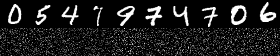

Epoch  0 - avg loss: 4.853922 (rec: 0.7227, reg: 41.3121)
Epoch  0 - avg loss: 1.168315 (rec: 0.7107, reg: 4.5762)
Epoch  0 - avg loss: 0.986170 (rec: 0.7107, reg: 2.7549)
Epoch  0 - avg loss: 0.893321 (rec: 0.7107, reg: 1.8265)
Epoch  0 - avg loss: 0.837964 (rec: 0.7106, reg: 1.2732)


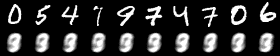

Epoch  0 - avg loss: 0.801782 (rec: 0.7104, reg: 0.9133)
Epoch  0 - avg loss: 0.777804 (rec: 0.7104, reg: 0.6737)
Epoch  0 - avg loss: 0.761609 (rec: 0.7104, reg: 0.5119)
Epoch  0 - avg loss: 0.751300 (rec: 0.7103, reg: 0.4103)
Epoch  0 - avg loss: 0.744253 (rec: 0.7102, reg: 0.3408)


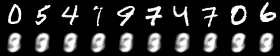

In [ ]:
# sanity check
loader = DataLoader(data, batch_size=256, shuffle=True, num_workers=4)
trainer.train(loader, num_epochs=10)

In [ ]:
mean = torch.zeros(10, 20).to(device)
log_var = torch.zeros(10, 20).to(device)  # You can adjust log_var according to your requirements
out1 = data_to_image(*vae.generate(mean, log_var))
out2 = data_to_image(*vae.generate(mean, log_var))
out3 = data_to_image(*vae.generate(mean, log_var))
